In [1]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm
# Cargar el dataset
df = pd.read_csv('Amazon_dataset/customer_review_amazon_products.csv')

# Verificar las columnas del DataFrame
print("Columnas en el DataFrame:")
print(df.columns.tolist())

# Verificar algunos valores únicos
print("\nEjemplos de nombres de productos:")
print(df['name'].unique()[:5])
print("\nRango de ratings:")
print(df['reviews.rating'].unique())


c:\Users\edwar\anaconda3\envs\nlp_cuda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Columnas en el DataFrame:
['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer', 'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.userCity', 'reviews.userProvince', 'reviews.username']

Ejemplos de nombres de productos:
['All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta'
 'Kindle Oasis E-reader with Leather Charging Cover - Merlot, 6 High-Resolution Display (300 ppi), Wi-Fi - Includes Special Offers,,'
 'Amazon Kindle Lighted Leather Cover,,,\r\nAmazon Kindle Lighted Leather Cover,,,'
 'Amazon Kindle Lighted Leather Cover,,,\r\nKindle Keyboard,,,'
 'Kindle Keyboard,,,\r\nKindle Keyboard,,,']

Rango de ratings:
[ 5.  4.  2.  1.  3. nan]


C:\Users\edwar\AppData\Local\Temp\ipykernel_15568\2282915387.py:15: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Amazon_dataset/customer_review_amazon_products.csv')


In [2]:
# Preprocesamiento básico
def preprocess_data(df):
    # Eliminar filas con valores nulos en el texto y ratings
    df = df.dropna(subset=['reviews.text', 'reviews.rating'])
    
    # Asegurarse de que los textos sean strings
    df['reviews.text'] = df['reviews.text'].astype(str)
    
    # Convertir ratings a float y eliminar valores no válidos
    df['reviews.rating'] = pd.to_numeric(df['reviews.rating'], errors='coerce')
    df = df[df['reviews.rating'].notna()]  # Eliminar filas con ratings NaN
    
    # Convertir ratings a sentimientos
    df['sentiment'] = df['reviews.rating'].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))
    
    # Limpiar textos muy cortos o muy largos
    df = df[df['reviews.text'].str.len() > 10]  # eliminar textos muy cortos
    df = df[df['reviews.text'].str.len() < 512]  # eliminar textos muy largos
    
    # Limpiar nombres de productos
    df['name'] = df['name'].str.strip()
    
    # Verificar el resultado del preprocesamiento
    print("\nDespués del preprocesamiento:")
    print(f"Número total de reviews: {len(df)}")
    print("\nDistribución de ratings:")
    print(df['reviews.rating'].value_counts().sort_index())
    print("\nDistribución de sentimientos:")
    print(df['sentiment'].value_counts().sort_index())
    
    return df

df = preprocess_data(df)

# Verificar que no hay valores NaN después del preprocesamiento
print("\nVerificación final:")
print("Valores NaN en ratings:", df['reviews.rating'].isna().sum())
print("Valores NaN en textos:", df['reviews.text'].isna().sum())




Después del preprocesamiento:
Número total de reviews: 33506

Distribución de ratings:
reviews.rating
1.0      367
2.0      363
3.0     1404
4.0     8200
5.0    23172
Name: count, dtype: int64

Distribución de sentimientos:
sentiment
0      730
1     1404
2    31372
Name: count, dtype: int64

Verificación final:
Valores NaN en ratings: 0
Valores NaN en textos: 0


C:\Users\edwar\AppData\Local\Temp\ipykernel_15568\2153409065.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reviews.text'] = df['reviews.text'].astype(str)
C:\Users\edwar\AppData\Local\Temp\ipykernel_15568\2153409065.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reviews.rating'] = pd.to_numeric(df['reviews.rating'], errors='coerce')


In [3]:
# Verificar las columnas del DataFrame
print("Columnas en el DataFrame:")
print(df.columns.tolist())

# Verificar algunos valores únicos
print("\nEjemplos de nombres de productos:")
print(df['name'].unique()[:5])
print("\nRango de ratings:")
print(df['reviews.rating'].unique())


Columnas en el DataFrame:
['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer', 'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'sentiment']

Ejemplos de nombres de productos:
['All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta'
 'Kindle Oasis E-reader with Leather Charging Cover - Merlot, 6 High-Resolution Display (300 ppi), Wi-Fi - Includes Special Offers,,'
 'All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Magenta'
 'Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Tangerine - with Special Offers,'
 'Amazon 5W USB Official OEM Charger and Power Adapter for Fire Tablets and Kindle eReaders,,,\r\nAmazon 5W USB Official OEM Charger and Power Adapter for Fire Tablets and Kindl

In [4]:
# Dividir los datos
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['reviews.text'].tolist(),
    df['sentiment'].tolist(),
    test_size=0.2,
    random_state=42
)

# Cargar el tokenizer y modelo BERT
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3
)

# Crear función para tokenización
def tokenize_data(texts):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Dataset personalizado

class ReviewDataset(Dataset):
    def __init__(self, texts, labels):
        # Convertir textos a lista y asegurarse de que sean strings
        self.texts = [str(text) for text in texts]
        self.labels = labels
        self.encodings = tokenize_data(self.texts)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Cargar el tokenizer y modelo BERT
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3
)

# Crear datasets
train_dataset = ReviewDataset(train_texts, train_labels)
val_dataset = ReviewDataset(val_texts, val_labels)

# Configurar dataloaders con un tamaño de batch más pequeño
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Entrenamiento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
from tqdm import tqdm
from sklearn.metrics import f1_score
# Función de entrenamiento
def train_model(model, train_loader, val_loader, epochs=3):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        batch_count = 0
        print(f'\nEpoch {epoch+1}/{epochs}')
        print('-' * 40)
        
        # Crear barra de progreso para el entrenamiento
        progress_bar = tqdm(total=len(train_loader), desc='Training')
        
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            train_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
            batch_count += 1
            # Actualizar barra de progreso con pérdida actual
            progress_bar.set_postfix({'loss': f'{train_loss/batch_count:.4f}'})
            progress_bar.update(1)
            
        progress_bar.close()
        avg_train_loss = train_loss / len(train_loader)
        print(f'\nAverage training loss: {avg_train_loss:.4f}')
            
        # Validación
        print('\nStarting validation...')
        model.eval()
        val_preds = []
        val_true = []
        val_loss = 0
        
        # Crear barra de progreso para la validación
        progress_bar = tqdm(total=len(val_loader), desc='Validating')
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += outputs.loss.item()
                predictions = torch.argmax(outputs.logits, dim=-1)
                
                val_preds.extend(predictions.cpu().numpy())
                val_true.extend(labels.cpu().numpy())
                progress_bar.update(1)
        
        progress_bar.close()
        avg_val_loss = val_loss / len(val_loader)
        
        # Calcular métricas
        accuracy = accuracy_score(val_true, val_preds)
        f1 = f1_score(val_true, val_preds, average='weighted')
        print(f'\nResults for epoch {epoch+1}:')
        print(f'Average validation loss: {avg_val_loss:.4f}')
        print(f'Validation Accuracy: {accuracy:.4f}')
        print(f'Validation F1 Score: {f1:.4f}')
        print('\nDetailed Classification Report:')
        print(classification_report(val_true, val_preds))
        print('-' * 80 + '\n')

# Entrenar el modelo
train_model(model, train_loader, val_loader)



Epoch 1/3
----------------------------------------


Training: 100%|██████████| 838/838 [04:19<00:00,  3.23it/s, loss=0.2025]



Average training loss: 0.2025

Starting validation...


Validating: 100%|██████████| 210/210 [00:20<00:00, 10.30it/s]



Results for epoch 1:
Average validation loss: 0.1600
Validation Accuracy: 0.9484
Validation F1 Score: 0.9328

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.64      0.64       135
           1       0.47      0.06      0.11       278
           2       0.96      0.99      0.98      6289

    accuracy                           0.95      6702
   macro avg       0.69      0.57      0.57      6702
weighted avg       0.93      0.95      0.93      6702

--------------------------------------------------------------------------------


Epoch 2/3
----------------------------------------


Training: 100%|██████████| 838/838 [04:20<00:00,  3.21it/s, loss=0.1336]



Average training loss: 0.1336

Starting validation...


Validating: 100%|██████████| 210/210 [00:20<00:00, 10.34it/s]



Results for epoch 2:
Average validation loss: 0.1649
Validation Accuracy: 0.9472
Validation F1 Score: 0.9373

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.50      0.57       135
           1       0.41      0.17      0.24       278
           2       0.96      0.99      0.98      6289

    accuracy                           0.95      6702
   macro avg       0.68      0.55      0.60      6702
weighted avg       0.93      0.95      0.94      6702

--------------------------------------------------------------------------------


Epoch 3/3
----------------------------------------


Training: 100%|██████████| 838/838 [04:20<00:00,  3.21it/s, loss=0.0950]



Average training loss: 0.0950

Starting validation...


Validating: 100%|██████████| 210/210 [00:20<00:00, 10.22it/s]


Results for epoch 3:
Average validation loss: 0.1746
Validation Accuracy: 0.9443
Validation F1 Score: 0.9419

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.50      0.57       135
           1       0.38      0.34      0.36       278
           2       0.97      0.98      0.98      6289

    accuracy                           0.94      6702
   macro avg       0.68      0.61      0.64      6702
weighted avg       0.94      0.94      0.94      6702

--------------------------------------------------------------------------------



## Evaluate the model

In [7]:
# Create a dataset with all the data
def evaluate_full_dataset(model, df, tokenizer, batch_size=32):
    """
    Evaluates the model on the complete dataset
    """
    print("\nEvaluating model on complete dataset...")
    print(f"Total samples: {len(df)}")
    
    # Create full dataset
    full_dataset = ReviewDataset(
        df['reviews.text'].tolist(),
        df['sentiment'].tolist()
    )
    
    # Create dataloader for full dataset
    full_loader = DataLoader(
        full_dataset, 
        batch_size=batch_size,
        shuffle=False
    )
    
    model.eval()
    all_preds = []
    all_true = []
    total_loss = 0
    
    # Add progress bar
    progress_bar = tqdm(total=len(full_loader), desc='Evaluating full dataset')
    
    with torch.no_grad():
        for batch in full_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            
            predictions = torch.argmax(outputs.logits, dim=-1)
            
            all_preds.extend(predictions.cpu().numpy())
            all_true.extend(labels.cpu().numpy())
            progress_bar.update(1)
    
    progress_bar.close()
    
    # Calculate metrics
    accuracy = accuracy_score(all_true, all_preds)
    f1 = f1_score(all_true, all_preds, average='weighted')
    avg_loss = total_loss / len(full_loader)
    
    # Print results
    print('\n' + '='*50)
    print('Full Dataset Evaluation Results:')
    print('='*50)
    print(f'Average Loss: {avg_loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1 Score (weighted): {f1:.4f}')
    
    print('\nDetailed Classification Report:')
    print('-'*50)
    print(classification_report(all_true, all_preds))
    
    print('\nConfusion Matrix:')
    print('-'*50)
    cm = confusion_matrix(all_true, all_preds)
    print(cm)
    
    # Calculate and print class distribution
    print('\nPredicted Class Distribution:')
    print('-'*50)
    pred_dist = pd.Series(all_preds).value_counts().sort_index()
    print('Predicted:', pred_dist.to_dict())
    
    print('\nTrue Class Distribution:')
    true_dist = pd.Series(all_true).value_counts().sort_index()
    print('Actual:', true_dist.to_dict())
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'f1': f1,
        'predictions': all_preds,
        'true_labels': all_true,
        'confusion_matrix': cm
    }

# Call the function to evaluate on full dataset
full_results = evaluate_full_dataset(model, df, tokenizer)


Evaluating model on complete dataset...
Total samples: 33506


Evaluating full dataset: 100%|██████████| 1048/1048 [01:42<00:00, 10.22it/s]



Full Dataset Evaluation Results:
Average Loss: 0.0755
Accuracy: 0.9795
F1 Score (weighted): 0.9787

Detailed Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       730
           1       0.82      0.70      0.76      1404
           2       0.99      1.00      0.99     31372

    accuracy                           0.98     33506
   macro avg       0.90      0.85      0.87     33506
weighted avg       0.98      0.98      0.98     33506


Confusion Matrix:
--------------------------------------------------
[[  615    76    39]
 [   71   985   348]
 [   17   136 31219]]

Predicted Class Distribution:
--------------------------------------------------
Predicted: {0: 703, 1: 1197, 2: 31606}

True Class Distribution:
Actual: {0: 730, 1: 1404, 2: 31372}


## Visualization


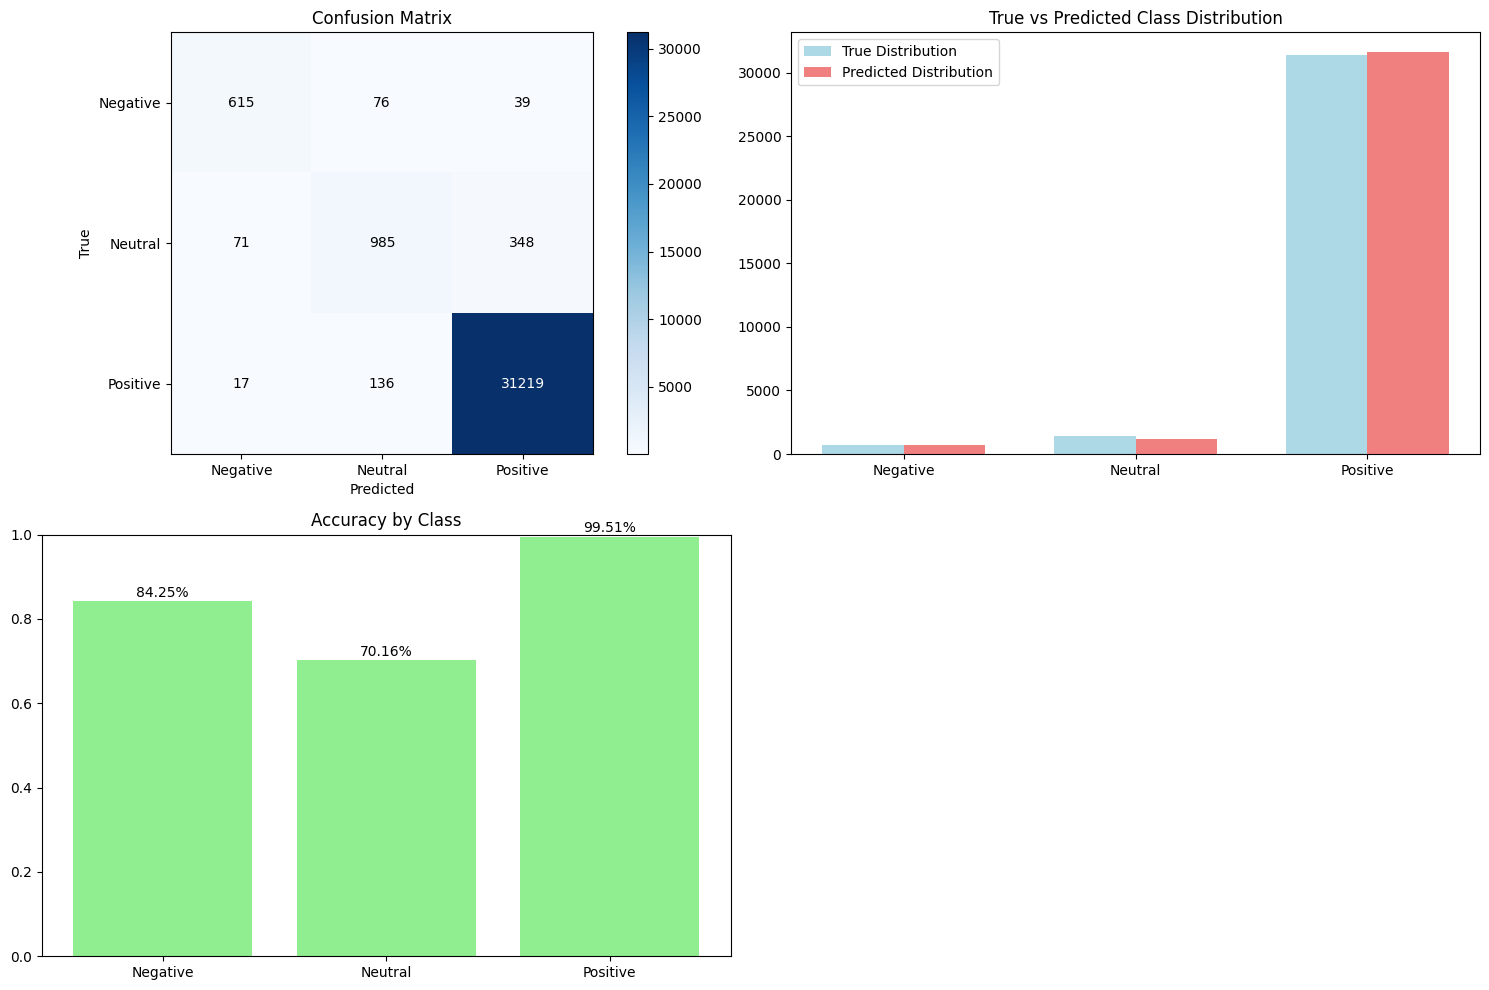


Summary Metrics:
Overall Accuracy: 0.9795
Overall F1 Score: 0.9787
Loss: 0.0755


In [8]:
def visualize_results(results):
    """
    Creates visualizations for model evaluation results
    """
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(15, 10))
    
    # 1. Confusion Matrix Heatmap
    plt.subplot(2, 2, 1)
    cm = results['confusion_matrix']
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.colorbar()
    
    # Add text annotations to confusion matrix
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])
    plt.yticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])

    # 2. Class Distribution Comparison
    plt.subplot(2, 2, 2)
    true_dist = pd.Series(results['true_labels']).value_counts().sort_index()
    pred_dist = pd.Series(results['predictions']).value_counts().sort_index()
    
    x = np.arange(3)
    width = 0.35
    
    plt.bar(x - width/2, true_dist, width, label='True Distribution', color='lightblue')
    plt.bar(x + width/2, pred_dist, width, label='Predicted Distribution', color='lightcoral')
    
    plt.xticks(x, ['Negative', 'Neutral', 'Positive'])
    plt.title('True vs Predicted Class Distribution')
    plt.legend()
    
    # 3. Prediction Accuracy by Class
    plt.subplot(2, 2, 3)
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    plt.bar(['Negative', 'Neutral', 'Positive'], class_accuracy, color='lightgreen')
    plt.title('Accuracy by Class')
    plt.ylim(0, 1)
    
    # Add percentage labels on bars
    for i, v in enumerate(class_accuracy):
        plt.text(i, v + 0.01, f'{v:.2%}', ha='center')

    plt.tight_layout()
    plt.show()
    
    # Save the plot
    fig.savefig('model_evaluation_results.png')
    
    # Print summary metrics
    print("\nSummary Metrics:")
    print(f"Overall Accuracy: {results['accuracy']:.4f}")
    print(f"Overall F1 Score: {results['f1']:.4f}")
    print(f"Loss: {results['loss']:.4f}")

# After running the full evaluation, visualize the results
visualize_results(full_results)

## Dashboard


In [16]:
#!pip install plotly kaleido

In [28]:
# Import required libraries
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import nbformat

def create_interactive_dashboard(results, df):
    """
    Creates an interactive dashboard using Plotly
    """
    try:
        # Create subplot layout with increased vertical spacing
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=(
                'Confusion Matrix',
                'Class Distribution Comparison', 
                'Accuracy by Class',
                'Rating Distribution'
            ),
            vertical_spacing=0.25,  # Increased from 0.15 to 0.25
            horizontal_spacing=0.1
        )
        
        # 1. Confusion Matrix Heatmap
        cm = results['confusion_matrix']
        heatmap = go.Heatmap(
            z=cm,
            x=['Negative', 'Neutral', 'Positive'],
            y=['Negative', 'Neutral', 'Positive'],
            text=cm,
            texttemplate="%{text}",
            textfont={"size": 16},
            colorscale='Blues'
        )
        fig.add_trace(heatmap, row=1, col=1)
        
        # 2. Class Distribution Comparison
        true_dist = pd.Series(results['true_labels']).value_counts().sort_index()
        pred_dist = pd.Series(results['predictions']).value_counts().sort_index()
        
        # Ensure all classes are represented
        for i in range(3):  # 0, 1, 2
            if i not in true_dist:
                true_dist[i] = 0
            if i not in pred_dist:
                pred_dist[i] = 0
        
        true_dist = true_dist.sort_index()
        pred_dist = pred_dist.sort_index()
        
        fig.add_trace(
            go.Bar(
                x=['Negative', 'Neutral', 'Positive'],
                y=true_dist,
                name='True Distribution',
                marker_color='lightblue'
            ),
            row=1, col=2
        )
        
        fig.add_trace(
            go.Bar(
                x=['Negative', 'Neutral', 'Positive'],
                y=pred_dist,
                name='Predicted Distribution',
                marker_color='lightcoral'
            ),
            row=1, col=2
        )
        
        # 3. Accuracy by Class
        class_accuracy = cm.diagonal() / np.maximum(cm.sum(axis=1), 1)  # Avoid division by zero
        fig.add_trace(
            go.Bar(
                x=['Negative', 'Neutral', 'Positive'],
                y=class_accuracy,
                text=[f'{v:.2%}' for v in class_accuracy],
                textposition='outside',
                marker_color='lightgreen',
                showlegend=False
            ),
            row=2, col=1
        )
        
        # 4. Original Rating Distribution
        rating_counts = df['reviews.rating'].value_counts().sort_index()
        fig.add_trace(
            go.Bar(
                x=rating_counts.index.astype(str),
                y=rating_counts.values,
                name='Rating Distribution',
                marker_color='purple',
                showlegend=False
            ),
            row=2, col=2
        )
        
        # Update layout with increased height and margins
        fig.update_layout(
            height=1200,  # Increased from 1000 to 1200
            width=1200,
            title_text="Model Evaluation Dashboard",
            title_x=0.5,
            title_y=0.98,  # Moved title higher
            margin=dict(t=200, b=100),  # Increased top and bottom margins
            showlegend=True,
            template='plotly_white'
        )
        
        # Add metric cards with adjusted positioning
        metrics = [
            ('Overall Accuracy', f"{results['accuracy']:.4f}"),
            ('Overall F1 Score', f"{results['f1']:.4f}"), 
            ('Loss', f"{results['loss']:.4f}")
        ]
        
        for i, (metric_name, value) in enumerate(metrics):
            x_pos = 0.2 + (i * 0.3)
            
            fig.add_annotation(
                xref="paper", yref="paper",
                x=x_pos,
                y=1.15,  # Moved metrics higher
                text=f"<b>{metric_name}</b><br>{value}",
                showarrow=False,
                font=dict(size=14),
                align="center",
                bgcolor="rgba(255, 255, 255, 0.9)",
                bordercolor="rgba(0, 0, 0, 0.3)",
                borderwidth=2,
                borderpad=10,
                width=150,
                height=80
            )
        
        # Update axes labels
        fig.update_xaxes(title_text="Sentiment", row=2, col=1)
        fig.update_xaxes(title_text="Rating", row=2, col=2)
        fig.update_yaxes(title_text="Count", row=1, col=2)
        fig.update_yaxes(title_text="Accuracy", row=2, col=1)
        fig.update_yaxes(title_text="Count", row=2, col=2)
        
        # Show the dashboard
        fig.show()
        
        # Save to HTML
        fig.write_html("model_evaluation_dashboard.html")
        
        print("Main dashboard created successfully!")
        
        # Additional visualizations
        try:
            # 1. Review Length Distribution
            df['review_length'] = df['reviews.text'].str.len()
            fig_length = px.histogram(
                df, 
                x='review_length',
                title='Distribution of Review Lengths',
                labels={'review_length': 'Review Length (characters)', 'count': 'Count'},
                color_discrete_sequence=['purple']
            )
            fig_length.show()
            fig_length.write_html("review_length_distribution.html")
            print("Review length distribution created successfully!")
            
            # 2. Rating vs Sentiment Correlation
            fig_correlation = px.scatter(
                df,
                x='reviews.rating',
                y='sentiment',
                title='Rating vs Predicted Sentiment Correlation',
                labels={'reviews.rating': 'Rating', 'sentiment': 'Sentiment'},
                color_discrete_sequence=['blue']
            )
            fig_correlation.show()
            fig_correlation.write_html("rating_sentiment_correlation.html")
            print("Rating-sentiment correlation plot created successfully!")
            
        except Exception as e:
            print(f"Error in additional visualizations: {str(e)}")
            
    except Exception as e:
        print(f"Error creating dashboard: {str(e)}")
        raise

# Create the dashboard with error handling
try:
    create_interactive_dashboard(full_results, df)
except Exception as e:
    print(f"Failed to create dashboard: {str(e)}")

Main dashboard created successfully!


Review length distribution created successfully!


Rating-sentiment correlation plot created successfully!
